In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import ConstructPortfolio as cp #this will allow us to modularize the code!
#using "ConstructPortfolio.py" that is stored in the same directory! 
#(not using "ConstructPortfolio.ipynb")


/Users/bardiafarajnejad/Desktop/1st Half MFE/AFP/Final Delivery/MFE Group 16 AFP Code


# Trading on earnings suprises (when using midpoint) is not super informative... buy days do slighly better than sell days

# Both buy and sell have high SR of 0.8-0.9 (on 20%+ returns) but low IR of 0.2 (on 2% alpha)

In [5]:
#### Please run the line below once in order to get "data_with_rets.pkl" from "afp_data_sample_1995_onward_v2.csv"
#cp.get_data(flag=True)

data = pd.read_pickle('data_with_rets.pkl')
data.columns.values
data['duedate']

0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
              ...    
2912427    20210831.0
2912428           NaN
2912429           NaN
2912430           NaN
2912431           NaN
Name: duedate, Length: 2912432, dtype: float64

In [6]:
data['duedate'] = pd.to_datetime(data['duedate'], format='%Y%m%d', errors='ignore')
data['duedate']


0                NaT
1                NaT
2                NaT
3                NaT
4                NaT
             ...    
2912427   2021-08-31
2912428          NaT
2912429          NaT
2912430          NaT
2912431          NaT
Name: duedate, Length: 2912432, dtype: datetime64[ns]

### "report_date Momentum": there will potentially be information in past returns 10 days prior to 'report_date'

### Now, let's trade on report_date Momentum!
### the times when 'ret10d' > 0 or < 0 on report_date
###### Buy when 'ret10d' > 0, so when df['ret10d'] > 0 on report_date
###### Sell when 'ret10d' < 0, so when df['ret10d'] < 0 on report_date
### with 1 day, 1 week, 2 weeks, 3 weeks, and 4 weeks holding period 
### (AHEAD, not backward... so our ret, ret5d, 10d, 15d, and 20d needs to be forward)
### Thus, we will use ret5d_'lag' !!

# Set buy_tomorrow>0 when df['ret10d'] > 0 AND we are on report_date
# Set Sell_tomorrow>0 when df['ret10d'] < 0 AND we are on report_date


In [7]:
data = data.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()

data = data[data['ret10d'].notna()].reset_index(drop=True).copy()
data = data[data['duedate'].notna()].reset_index(drop=True).copy()

data['buy_tomorrow1'] = np.where(data['ret10d'] > 0.025, 1, 0)
data['sell_tomorrow1'] = np.where(data['ret10d'] < -0.025, 1, 0)

data['buy_tomorrow2'] = np.where(data['duedate']==data['date'], 1, 0)
data['sell_tomorrow2'] = np.where(data['duedate']==data['date'], 1, 0)

data['buy_tomorrow'] = data['buy_tomorrow1'] + data['buy_tomorrow2']
data['sell_tomorrow'] = data['sell_tomorrow1'] + data['sell_tomorrow2']

data['buy_tomorrow'] = np.where(data['buy_tomorrow']==2, 1, 0)
data['sell_tomorrow'] = np.where(data['sell_tomorrow']==2, 1, 0)


print('Total number of Buys: ',np.count_nonzero(data['buy_tomorrow']))
print('Total number of Sells: ',np.count_nonzero(data['sell_tomorrow']))

print('Unique buy_tomorrow values: ',np.unique(data['buy_tomorrow'])) #there are only 0 or 1 values in 'buy_tomorrow'
print('Unique sell_tomorrow values: ',np.unique(data['sell_tomorrow'])) #there are only 0 or 1 values in 'sell_tomorrow'


Total number of Buys:  3540
Total number of Sells:  2101
Unique buy_tomorrow values:  [0 1]
Unique sell_tomorrow values:  [0 1]


In [8]:
data = cp.trade_on_valid_lags_only(data)


There are  5  problems for buying

There are  0  problems for selling
Total number of Buys:  3535
Total number of Sells:  2101


# Now we can trade!
### Holding period of 1 week, 2 weeks, 3 weeks, and 4 weeks with equal weighted portfolios!

# First, create daily equal weighted portfolio weights and returns (NOT AT THE WEEKLY frequency because that will mess up the implementation of the portfolio!). Problem is:

##### Think (part 1): 1st signal on Monday- want to buy on Tuesday and hold for 1 week in an equal weighted portfolio
##### Think (part 2): 2nd signal on Thursday- want to buy on Friday and hold for 1 week in an equal weighted portfolio
##### Think (part 3): Will have overlapping portfolio between 1st and 2nd signal on Friday and on Monday

## Then, for 1 week, 2 week, 3 week, and 4 week holding periods, we must do the following:
##### extend "buy_tomorrow" and "sell_tomorrow" forward for 4 more trading days

In [9]:
data_smaller,data_smaller5,data_smaller10,data_smaller15,data_smaller20 = cp.pull_signal_forward(data)

data_smaller20 = cp.trade_on_valid_lags_only(data_smaller20)
data_smaller15 = cp.trade_on_valid_lags_only(data_smaller15)
data_smaller10 = cp.trade_on_valid_lags_only(data_smaller10)
data_smaller5 = cp.trade_on_valid_lags_only(data_smaller5)
data_smaller = cp.trade_on_valid_lags_only(data_smaller)


There are  4  problems for buying

There are  7  problems for selling
Total number of Buys:  68938
Total number of Sells:  41120

There are  3  problems for buying

There are  4  problems for selling
Total number of Buys:  51846
Total number of Sells:  30935

There are  3  problems for buying

There are  3  problems for selling
Total number of Buys:  34695
Total number of Sells:  20701

There are  2  problems for buying

There are  0  problems for selling
Total number of Buys:  17465
Total number of Sells:  10408

There are  0  problems for buying

There are  0  problems for selling
Total number of Buys:  3523
Total number of Sells:  2096


# First, do 1 day holding period: data_smaller
# Next, do 5 day holding period: data_smaller5
# Next, do 10 day holding period: data_smaller10
# Next, do 15 day holding period: data_smaller15
# Next, do 20 day holding period: data_smaller20



There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.512
Date:                Sat, 04 Dec 2021   Prob (F-statistic):              0.171
Time:                        18:50:50   Log-Likelihood:                 1479.2
No. Observations:                 939   AIC:                            -2944.
Df Residuals:                     932   BIC: 

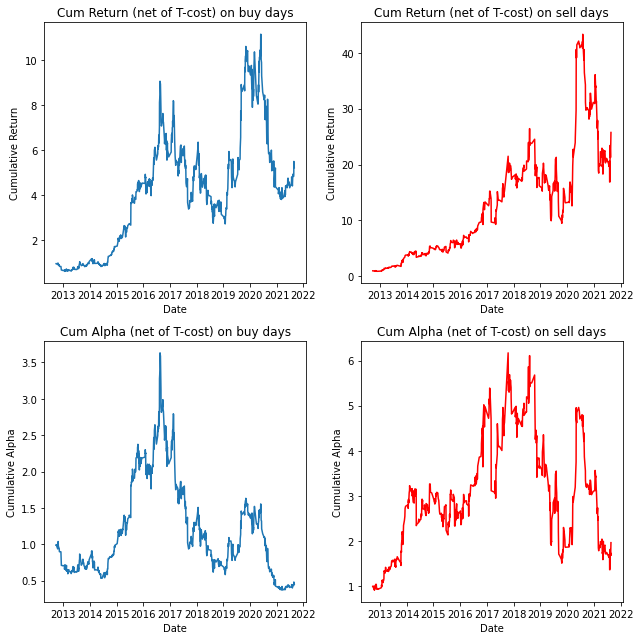

In [10]:
# 1 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.154
Date:                Sat, 04 Dec 2021   Prob (F-statistic):              0.329
Time:                        18:51:12   Log-Likelihood:                 3946.7
No. Observations:                1742   AIC:                            -7879.
Df Residuals:                    1735   BIC: 

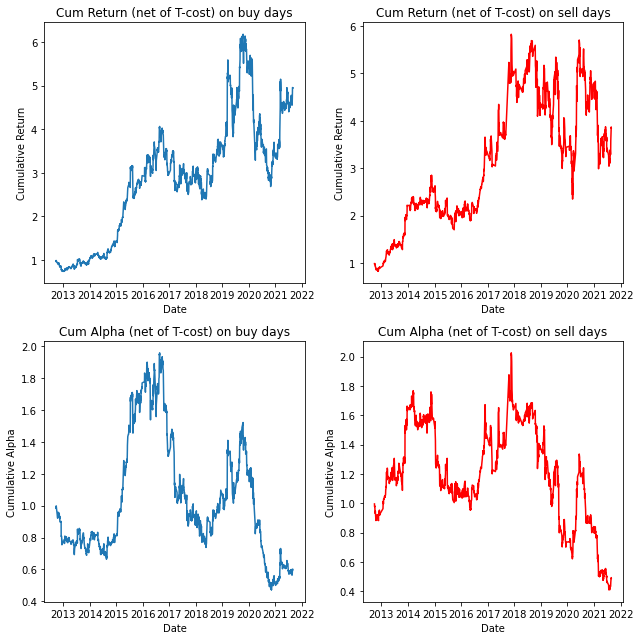

In [11]:
# 5 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller5)


There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.808
Date:                Sat, 04 Dec 2021   Prob (F-statistic):             0.0938
Time:                        18:51:36   Log-Likelihood:                 5159.7
No. Observations:                2041   AIC:                        -1.031e+04
Df Residuals:                    2034   BIC: 

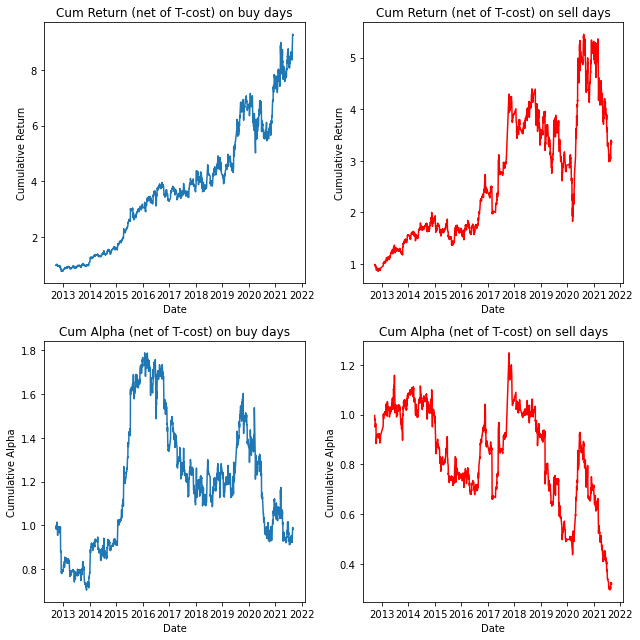

In [12]:
# 10 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller10)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.254
Date:                Sat, 04 Dec 2021   Prob (F-statistic):            0.00346
Time:                        18:52:02   Log-Likelihood:                 5589.8
No. Observations:                2174   AIC:                        -1.117e+04
Df Residuals:                    2167   BIC: 

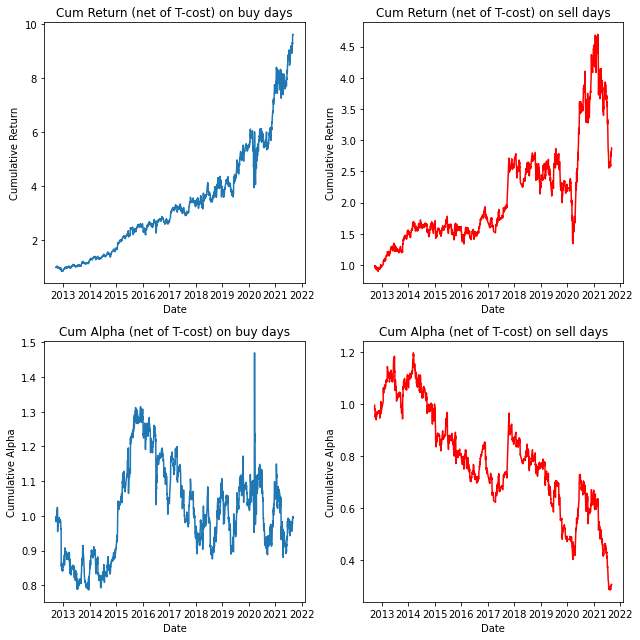

In [13]:
# 15 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller15)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     10.10
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           4.92e-11
Time:                        18:52:30   Log-Likelihood:                 5916.8
No. Observations:                2221   AIC:                        -1.182e+04
Df Residuals:                    2214   BIC: 

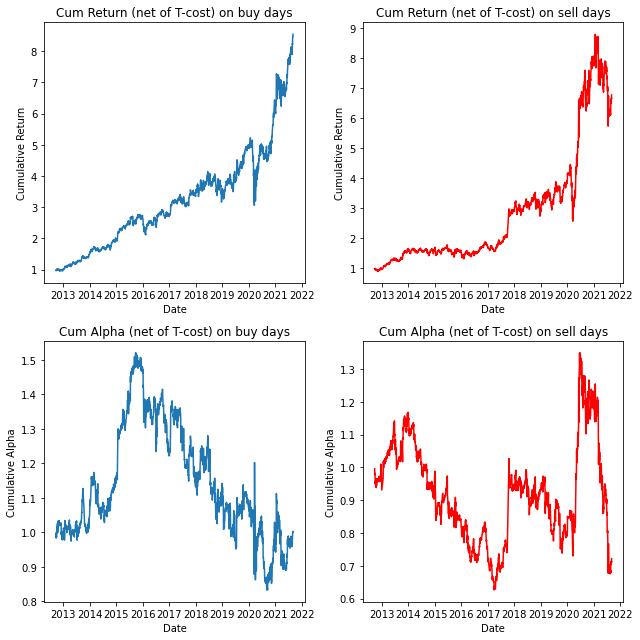

In [14]:
# 20 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller20)